In [30]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import pandas as pd
import numpy as np
import tensorflow as tf
import re
from gensim.models import Word2Vec

### Load the training Data

In [31]:
train = pd.read_csv("dataset/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

In [32]:
def split_sentence(sentence):
    reg1 = re.compile(r"\x3C.{1,8}\x3E")
    reg2 = re.compile("[^a-zA-Z0-9]")
    a = re.sub(reg1,"",sentence)
    b = re.sub(reg2," ",a)
    return b.lower().split()

In [33]:
sentences = list()

for review in train["review"].values:
    sentences.append(split_sentence(review))

###### Load the Gensim Model

In [34]:
model = Word2Vec.load("imdb_word2Vec_50")

In [35]:
Y_train = np.zeros((2,train['sentiment'].shape[0]), dtype=np.int16)
Y_train[0,:] = train['sentiment'].values
Y_train[1,:] = np.absolute(train['sentiment'].values - 1)
Y_train = Y_train.T

In [36]:
def batches(num):
    i = batch_size
    start  = (num*i)
    end = (num*i) + i
    return start, end

###### Find optimal word length

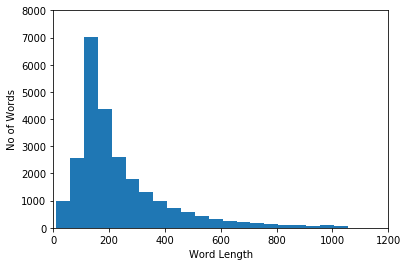

In [37]:
num_words = list()
for sents in sentences:
    num_words.append(len(sents))
    

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(num_words, 50)
plt.xlabel('Word Length')
plt.ylabel('No of Words')
plt.axis([0, 1200, 0, 8000])
plt.show()

In [38]:
batch_size = 25
num_classes = 2
epochs = 50
lstm_units = 64
# learning_rate = 0.001
num_dims = model.wv.vectors.shape[1]
optimal_len = 250
num_examples = len(sentences)

In [39]:
id_matrix = np.zeros((num_examples, optimal_len), dtype='int32')
for i in range(num_examples):
    for j in range(len(sentences[i])):
        if j < optimal_len:
            try:
                id_matrix[i,j] = model.wv.vocab.get(sentences[i][j]).index
            except AttributeError:
                id_matrix[i,j] = 0 # for unknow words

In [40]:
tf.reset_default_graph()

# lookup
idx = tf.placeholder(tf.int32, [batch_size, optimal_len], name="idx")
vectors = tf.Variable(tf.constant(model.wv.vectors))
X_embedd = tf.nn.embedding_lookup(vectors, idx)

In [41]:
X = tf.placeholder(tf.float32, [batch_size, optimal_len, num_dims],name="X")
Y = tf.placeholder(tf.float32, [batch_size, num_classes], name="Y")

In [42]:
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(lstm_units)
lstm_cell = tf.nn.rnn_cell.DropoutWrapper(cell=lstm_cell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstm_cell, X, dtype=tf.float32)

In [43]:
weight = tf.Variable(tf.truncated_normal([lstm_units, num_classes]))
bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [44]:
y_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(Y, 1))

accuracy = tf.reduce_mean(tf.cast(y_pred, tf.float32))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=Y))

In [45]:
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer().minimize(loss)

###### Setup Tensorboard

In [46]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = ".\\tensorboard\\" + datetime.datetime.now().strftime("%Y_%m_%d-%H%M%S")

###### Training

In [47]:
with tf.Session() as sess:
    
    #initializer
    writer = tf.summary.FileWriter(logdir, sess.graph)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    sess.run(init)
    itera = 0
    for e in range(epochs):
        
        for batch in range(Y_train.shape[0]//batch_size):
            
            #helper function
            start, end = batches(batch)
            
            #curren batch
            Y_batch = Y_train[start:end,:]
            X_batch = id_matrix[start:end,:]

            #find embedding for current batch
            X_value = sess.run(X_embedd, {idx: X_batch})
            #train the model 
            opt = sess.run(optimizer, {X: X_value, Y: Y_batch})
            
            # add summary every 10 iteration
            if batch %10 == 0:
                summary = sess.run(merged, {X: X_value, Y: Y_batch})
                writer.add_summary(summary, itera)
                
            # print cost and train accuracy every 50 iteration
            if batch % 100 == 0:
                cost, acc = sess.run([loss, accuracy], {X: X_value, Y: Y_batch})
                print("Epoch {}. Cost after {} iteration {:.3f} - acc {:.2f}".format(e ,itera, cost, acc))
                
            #total loop count
            itera+=1
            
        # save checkpoint every 10 epoch
        if e % 10 == 0:
            save_path = saver.save(sess,"models/Word2Vec_50/pre_trained_lstm.ckpt", global_step=e)
            
# close the summary writer
writer.close()

Epoch 0. Cost after 0 iteration 0.656 - acc 0.64
Epoch 0. Cost after 50 iteration 0.709 - acc 0.36
Epoch 0. Cost after 100 iteration 0.644 - acc 0.72
Epoch 0. Cost after 150 iteration 0.631 - acc 0.72
Epoch 0. Cost after 200 iteration 0.675 - acc 0.56
Epoch 0. Cost after 250 iteration 0.668 - acc 0.56
Epoch 0. Cost after 300 iteration 0.634 - acc 0.68
Epoch 0. Cost after 350 iteration 0.645 - acc 0.68
Epoch 0. Cost after 400 iteration 0.714 - acc 0.40
Epoch 0. Cost after 450 iteration 0.671 - acc 0.52


KeyboardInterrupt: 